In [214]:
from os import listdir
from os.path import isfile, join
import vaderSentiment
from collections import OrderedDict
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
from matplotlib import pyplot
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD
import re

import warnings
warnings.filterwarnings("ignore")

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from nltk.corpus import stopwords
import nltk

from gensim import corpora, models, similarities, matutils

# sklearn
from sklearn import datasets
from sklearn.feature_extraction.text import CountVectorizer

## Creating the dataframes

In [ ]:
comment_files = [f for f in listdir('/home/ubuntu/newyorktimes_nlp/data/comments') if isfile(join('/home/ubuntu/newyorktimes_nlp/data/comments', f))]
article_files = [f for f in listdir('/home/ubuntu/newyorktimes_nlp/data/articles') if isfile(join('/home/ubuntu/newyorktimes_nlp/data/articles', f))]

In [ ]:
# create data frame for comments
comment_df = pd.DataFrame(columns=['commentBody','newDesk','articleID'])
for file in comment_files:
    file = file.strip("'")
    df = pd.read_csv('/home/ubuntu/newyorktimes_nlp/data/comments/{}'.format(file),error_bad_lines=False, encoding = "ISO-8859-1")
    df = df[['commentBody','newDesk','articleID']]
    comment_df = comment_df.append(df)

In [ ]:
comment_df['commentBody'] = comment_df['commentBody'].astype(str)

In [ ]:
# filter for topics that had 200+ articles
comment_df = comment_df[comment_df['newDesk'].isin(['Arts&Leisure','BookReview','Business','Climate','Culture','Dining','Foreign','Games','Learning','National','Podcasts','RealEstate','Science','Sports','Travel','Washington'])]

In [ ]:
comment_df.shape

In [132]:
comment_df = pd.read_pickle("./comments.pkl")

In [ ]:
def get_compound(x):
    """
    Input a string of text and returns the vaderSentiment compound score
    """
    try:
        return analyser.polarity_scores(x)['compound']
    except:
        return 0

In [ ]:
# append compound score to the comments data frame
analyser = SentimentIntensityAnalyzer()
comment_df['compound'] = comment_df['commentBody'].apply(lambda x: get_compound(x))
with open('comments.pkl', 'wb') as output_file:
    pickle.dump(comment_df, output_file)

In [ ]:
articles = list(comment_df.articleID.unique())

In [ ]:
# create a new data frame that stores of the varience of each article

variance_df = pd.DataFrame(columns=['articleID','sentimentVariance'])

for article in articles: 
    sentiment = list(comment_df.loc[comment_df['articleID'] == article]['compound'])
    variance = np.var(sentiment)
    variance_df = variance_df.append({'articleID':article, 'sentimentVariance':variance},ignore_index=True)

In [ ]:
with open('sentiment.pkl', 'wb') as output_file:
    pickle.dump(variance_df, output_file)

In [ ]:
variance_df.head()

In [ ]:
variance_df.sentimentVariance.mean()

In [215]:
variance_df = pd.read_pickle("./sentiment.pkl")
variance_df = variance_df.dropna(axis=0)

## Plotting variance

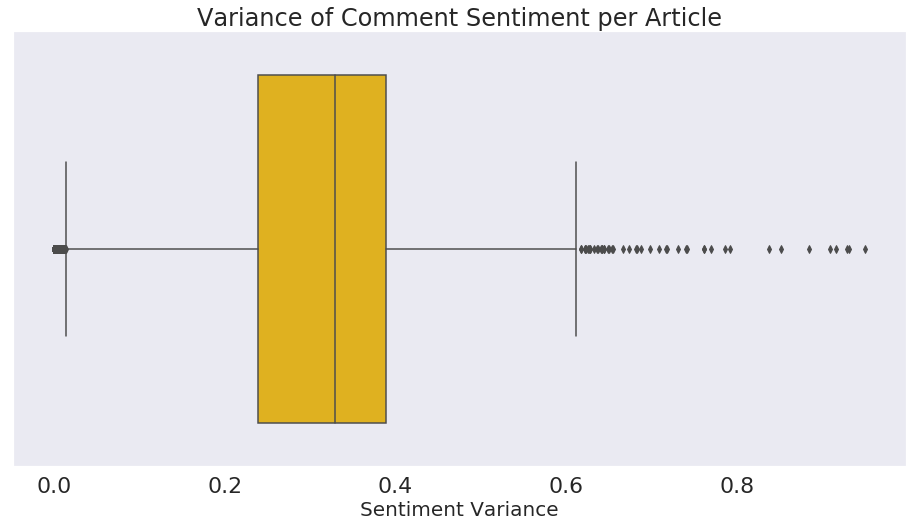

In [238]:
size = (16, 8)
fig, ax = pyplot.subplots(figsize=size)
sns.boxplot(x=variance_df.sentimentVariance,color='#FFC200').set_title('Variance of Comment Sentiment per Article')
ax.set_xlabel('Sentiment Variance',fontsize=20)
sns.set(font_scale = 2)
sns.set_style("dark")
ax.grid(False)


In [239]:
fig.savefig("variance.png")

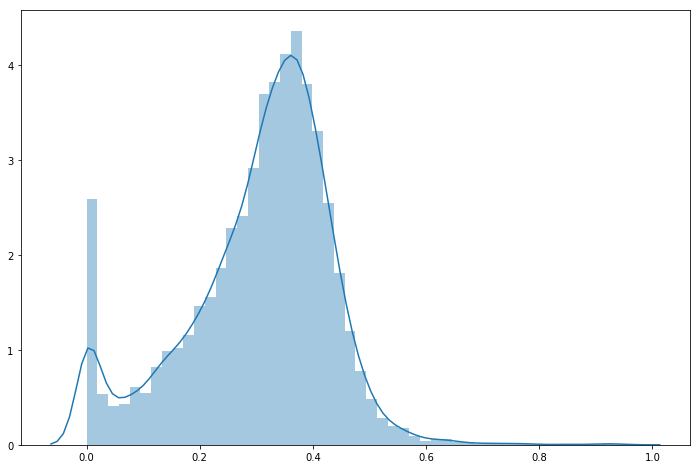

In [6]:
size = (12, 8)
fig, ax = pyplot.subplots(figsize=size)
x=list(variance_df.sentimentVariance)
sns.distplot(x)

## Selecting controversial articles

In [48]:
q1, q2, q3= np.percentile(list(variance_df.sentimentVariance),[25,50,75])
iqr = q3 - q1
lower_bound = q1 -(1.5 * iqr) 
upper_bound = q2 +(1.5 * iqr) 
print(lower_bound)
print(upper_bound)                      

0.014448804319950909
0.5534387918441649


In [49]:
# extracting the right bound outliers as the controversial articles
right_outliers =variance_df[variance_df['sentimentVariance'] >  upper_bound]
right_outliers[:5]

,articleID,sentimentVariance
153,5aafa21247de81a901212761,0.650417
190,5ab0b17447de81a901213053,0.596350
444,5ab8a88447de81a90121725f,0.682854
467,5ab90e4d47de81a901217568,0.649158
497,5ab9fa0547de81a901217bf5,0.557229


In [50]:
len(right_outliers)

95

In [51]:
with open('controversial.pkl', 'wb') as output_file:
    pickle.dump(right_outliers, output_file)

In [58]:
articles = pd.read_pickle("./articles.pkl")

In [104]:
articles['articleText'] = articles['articleText'].apply(lambda x: re.sub('[0-9]+', '', x))

In [105]:
# creating list of article text from controversial articles
contro_articles = right_outliers.articleID
contro_text = [articles.loc[articles['articleID'] == x].articleText for x in contro_articles]

## LDA

In [ ]:
words = nltk.corpus.stopwords.words('english')
add = ['articletext','dtype','series','sh','object','articletext dtype','dtype object','subscribe','article','nan','name','image','could','story']
for word in add:
    words.append(word)
docs = contro_text
docs = [str(i) for i in docs]
count_vectorizer = CountVectorizer(ngram_range=(1, 2),  
                                   stop_words=words, token_pattern="\\b[a-z][a-z]+\\b")
count_vectorizer.fit(docs)
doc_word = count_vectorizer.transform(docs).transpose()
corpus = matutils.Sparse2Corpus(doc_word)
id2word = dict((v, k) for k, v in count_vectorizer.vocabulary_.items())
lda = models.LdaModel(corpus=corpus, num_topics=3, id2word=id2word, passes=10)
lda.print_topics()

## NMF

In [212]:
vectorizer = CountVectorizer(stop_words = words)
doc_word = vectorizer.fit_transform(docs)
nmf_model = NMF(3)
doc_topic = nmf_model.fit_transform(doc_word)
topic_word = pd.DataFrame(nmf_model.components_.round(3),
             index = ['topic1','topic2','topic3'],
             columns = vectorizer.get_feature_names())

def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        
display_topics(nmf_model, vectorizer.get_feature_names(), 10)


Topic  0
said, one, would, people, also, like, new, many, black, civil

Topic  1
refugee, crisis, united, war, world, history, today, help, people, time

Topic  2
year, president, trump, first, office, think, new, policy, times, york


## LSA

In [213]:
lsa = TruncatedSVD(3)
doc_topic = lsa.fit_transform(doc_word)
topic_word = pd.DataFrame(lsa.components_.round(3),
             index = ['topic1','topic2','topic3'],
             columns = vectorizer.get_feature_names())
display_topics(lsa, vectorizer.get_feature_names(), 10)


Topic  0
said, people, refugee, crisis, united, history, one, world, would, new

Topic  1
crisis, refugee, war, world, united, today, help, history, sharps, text

Topic  2
year, president, trump, first, office, think, policy, presidency, analysis, new
